In [1]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import Select

In [2]:
data = pd.read_csv('C:/Users/HEESU/[opgg데이터분석가]/BIPA_data.csv',index_col = 0)
champStat = pd.read_csv('C:/Users/HEESU/[opgg데이터분석가]/champ_stats.csv',index_col=0)

In [3]:
tierPoint = {'I':0 , 'B':400, 'S':800, 'G':1200, 'P':1600, 'D':2000, 'M':2400, 'R':2800, 'C':3200}
inv_tierPoint = {0:'I',  1:'B', 2:'S', 3:'G', 4:'P', 5:'D', 6:'M', 7:'R', 8:'C'}

In [4]:
def get_meanTier(gameId):
    
    summonerRank = data[data['gameId']==gameId]['tierRank']
    cnt = 0
    pointSum = 0
    
    for tier in summonerRank:
        try:
            pointSum += tierPoint[tier[0]]
            pointSum += (4-int(tier[1]))*100
            cnt += 1
        except:
            pass
    
    if cnt == 0:
        return "0000"
        
    pointSum /= cnt
    tier = inv_tierPoint[int(pointSum/400)]
    division = math.ceil((400-pointSum%400)/100)
    temp = tier + str(division)

    return temp

In [5]:
nanTierList_idx = data[data['tierRank'].isnull()].index

In [6]:
for idx in nanTierList_idx:
    data.at[idx, 'tierRank'] = get_meanTier(data.iloc[idx]['gameId'])

In [7]:
data['tier'] = data['tierRank'].str[0]
data['division'] = data['tierRank'].str[1]
data = data.drop(['tierRank'], axis=1)
data.head(3)

,gameId,createDate,position,teamId,summonerId,championId,result,level,championsKilled,numDeaths,...,neutralMinionsKilledTeamJungle,visionScore,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,lane,gameLength,version,tier,division
0,5383880006,2021-08-11 06:59:31,S,200,3210877,99,WIN,10,4,1,...,0,11,2830,2181,2181,NONE,972,11.16.390.1945,P,3
1,5383880006,2021-08-11 06:59:31,S,100,7550211,35,LOSE,8,1,3,...,2,24,2013,0,0,NONE,972,11.16.390.1945,P,4
2,5383880006,2021-08-11 06:59:31,M,200,9306696,266,WIN,11,5,1,...,0,15,6158,585,585,NONE,972,11.16.390.1945,P,3


In [8]:
data = data[['tier', 'division', 'position', 'level', 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced', 'visionWardsBoughtInGame', 'wardKilled', 'goldEarned', 'totalDamageDealtToChampions', 'gameLength']]

In [9]:
nanidx = data[data['tier']=='0'].index
data = data.drop(nanidx)

In [10]:
################################################################

In [11]:
data.head(3)

,tier,division,position,level,minionsKilled,championsKilled,numDeaths,assists,wardPlaced,visionWardsBoughtInGame,wardKilled,goldEarned,totalDamageDealtToChampions,gameLength
0,P,3,S,10,15,4,1,5,5,1,1,6083,5590,972
1,P,4,S,8,7,1,3,3,6,3,3,4118,3827,972
2,P,3,M,11,100,5,1,5,7,4,5,6769,9467,972


In [12]:
data = data[data['gameLength'] >= 600]

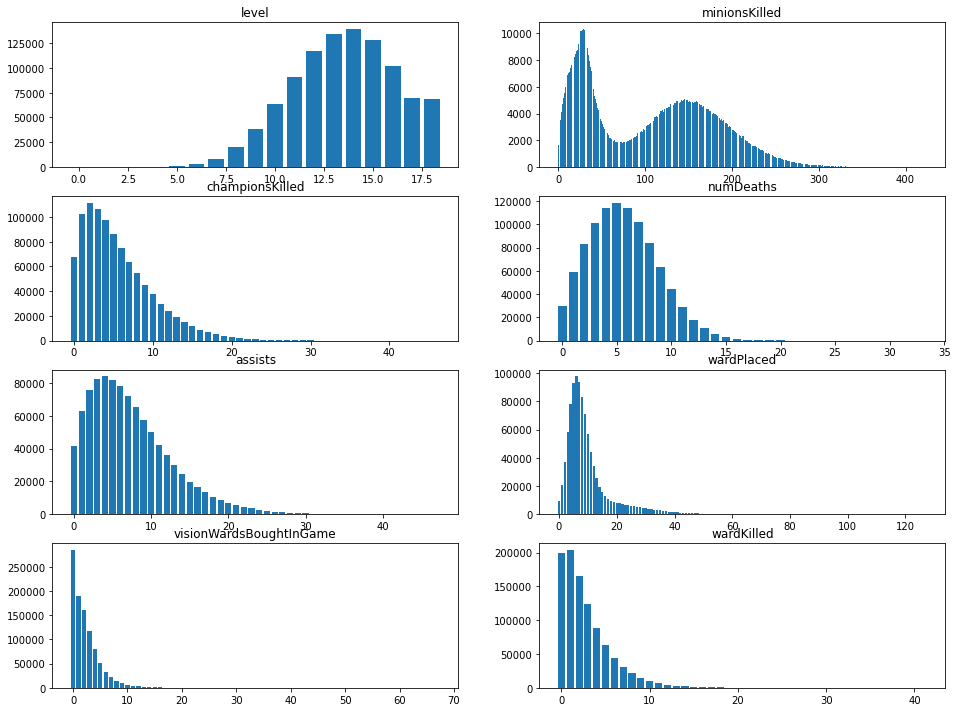

In [14]:
ind = 1
plt.figure(figsize=(16,16))
plt.subplots_adjust(bottom=0.001)

for col in ['level', 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced','visionWardsBoughtInGame', 'wardKilled']: 
    plt.subplot(6, 2, ind)
    plt.title(col)
    
    d = data[col]
    d_len = len(d.unique())
    d_num = [0 for i in range(d_len+1)]

    for i in range(d_len+1):
      d_num[i]=len(d[d==i])

    num = range(d_len+1)
    plt.bar(num, d_num)
    ind += 1

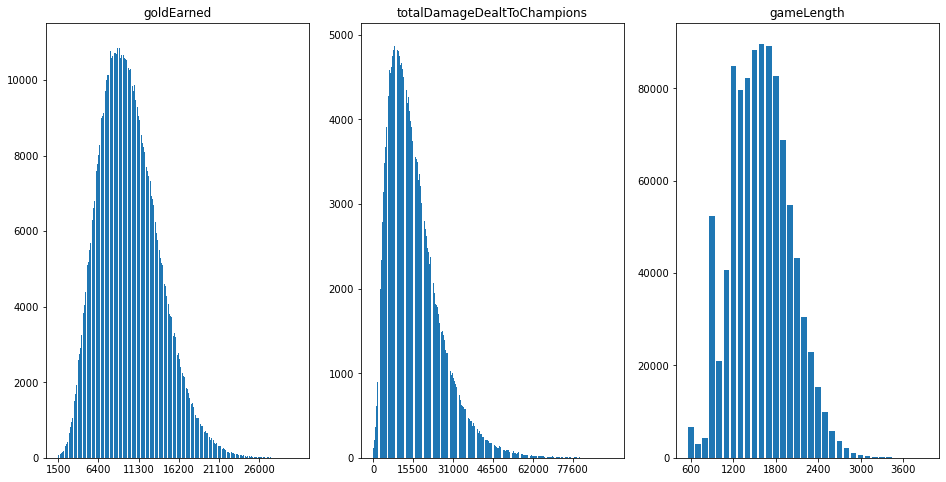

In [15]:
ind = 1
plt.figure(figsize=(16, 8))

for col in ['goldEarned', 'totalDamageDealtToChampions', 'gameLength']:
    plt.subplot(1, 3, ind)
    plt.title(col)

    d = data[col]
    d = round(d//100, 2) * 100

    uniquelist = sorted(list(d.unique()))
    length = len(uniquelist)

    y = [0 for _ in range(length)]
    for i in range(length):
        y[i] = len(d[d == uniquelist[i]])


    x = range(len(d.unique()))
    plt.bar(x, y)
    plt.xticks(x, uniquelist)
    plt.locator_params(axis='x', nbins=6)
    ind += 1

In [16]:
# 위에 그래프들을 통해서 --> 이상치 제거 기준을 세울 수 있다
# level : 하위 0.3퍼 제거
# 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced','visionWardsBoughtInGame', 'wardKilled' : 상위 0.3퍼 제거
# 'goldEarned', 'totalDamageDealtToChampions', 'gameLength' : 하위, 상위 0.3퍼 제거

In [17]:
processed_data = data
want_data = ['level', 'minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced', 'visionWardsBoughtInGame', 'wardKilled', 'goldEarned', 'totalDamageDealtToChampions', 'gameLength']
# 하위 0.3퍼, 상위 0.3퍼 데이터를 제거한다
for col in want_data:
    minimum = data[col].quantile(0.003)
    maximum = data[col].quantile(0.997)
    if col == 'level':
        processed_data = processed_data[data[col] > minimum]
    
    elif col in ['minionsKilled', 'championsKilled', 'numDeaths', 'assists', 'wardPlaced','visionWardsBoughtInGame', 'wardKilled']:
        processed_data = processed_data[data[col] < maximum]
    
    else:
         processed_data = processed_data[processed_data[col] < maximum]
         processed_data = processed_data[processed_data[col] > minimum]

        
# processed_data : 이상치가 제거된 데이터 
processed_data

<ipython-input-17-e849a57b4880>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-e849a57b4880>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-e849a57b4880>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-e849a57b4880>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-e849a57b4880>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum]
<ipython-input-17-e849a57b4880>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  processed_data = processed_data[data[col] < maximum

,tier,division,position,level,minionsKilled,championsKilled,numDeaths,assists,wardPlaced,visionWardsBoughtInGame,wardKilled,goldEarned,totalDamageDealtToChampions,gameLength
0,P,3,S,10,15,4,1,5,5,1,1,6083,5590,972
1,P,4,S,8,7,1,3,3,6,3,3,4118,3827,972
2,P,3,M,11,100,5,1,5,7,4,5,6769,9467,972
3,P,4,T,11,115,8,2,1,5,1,0,7972,10963,972
4,P,3,A,10,110,3,2,9,5,1,2,7552,6465,972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,S,1,S,15,29,1,11,7,29,4,7,8451,10019,2379
999996,G,4,M,18,251,10,6,3,8,0,1,18291,37581,2379
999997,G,4,J,17,40,5,5,22,13,3,2,12986,20994,2379
999998,S,1,A,17,260,6,5,3,11,1,4,15674,37078,2379


In [18]:
processed_data['gameLength'] /= 60

In [19]:
for it in processed_data.columns[3:len(processed_data.columns)-1]:
    processed_data[it] /= processed_data['gameLength']
processed_data = processed_data.drop(columns='gameLength')

In [20]:
processed_data.head(3)

,tier,division,position,level,minionsKilled,championsKilled,numDeaths,assists,wardPlaced,visionWardsBoughtInGame,wardKilled,goldEarned,totalDamageDealtToChampions
0,P,3,S,0.617284,0.925926,0.246914,0.061728,0.308642,0.308642,0.061728,0.061728,375.493827,345.061728
1,P,4,S,0.493827,0.432099,0.061728,0.185185,0.185185,0.370370,0.185185,0.185185,254.197531,236.234568
2,P,3,M,0.679012,6.172840,0.308642,0.061728,0.308642,0.432099,0.246914,0.308642,417.839506,584.382716


In [21]:
# 확인하고 싶은 아이디 입력
summoner_name = 'bbo bbo'

In [22]:
# selenium을 백그라운드로 실행하기 위해 옵션 설정
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('window-size=1920x1080')

In [23]:
# selenium으로 실행시킬 url설정
summoner_url = 'https://poro.gg/summoner/kr/' + summoner_name
chrome_driver_path = "C:/Users/HEESU/[opgg데이터분석가]/chromedriver"
driver = webdriver.Chrome(chrome_driver_path)

driver.get(summoner_url)

<ipython-input-23-4db4e85b1dc4>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chrome_driver_path)


In [24]:
# 솔로랭크의 자료만을 원하므로, 솔로랭크 버튼 클릭
solo_rank_button = driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(1) > div.summoner-box__content > div > div.match-history-filter__queue-types > button:nth-child(2)")
solo_rank_button.click()
time.sleep(2)

<ipython-input-24-0c252052034b>:2: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  solo_rank_button = driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(1) > div.summoner-box__content > div > div.match-history-filter__queue-types > button:nth-child(2)")


In [25]:
# 컨테이너의 정보들은, start가 3부터 시작해서, 1씩 더해지며 쌓인다.
# 각 컨테이너 마다 (+) 버튼 눌러주는 코드
start = 3
while True:
    try:
        driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(" + str(start) + ") > div > div.match-history__expand-toggle").click()
        time.sleep(0.5)
        start += 1
    
    except Exception as e:
        pass
        break

<ipython-input-25-f5ee5972c586>:6: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_css_selector("#vue-profile > div.match-history-container.mt-3 > div:nth-child(" + str(start) + ") > div > div.match-history__expand-toggle").click()


In [26]:
# 전체 펼친 html
summoner_html = driver.page_source
summoner_soup = BeautifulSoup(summoner_html, 'html.parser')

In [27]:
driver.quit()

In [28]:
# 불러오는 게임의 수
# games_len = len(summoner_games_html)

summoner_games_html = summoner_soup.select('div.match-history__content')
games_len = 13

In [29]:
# 확인하고 싶은 자료 선정
Damage = []
CS = []
Wardplaced = []
visionWardplaced = []
WardKilled = []
Kill = []
Death = []
Assist = []
Level = []
Gold = []
Gamelength = []
Position = []

In [30]:
# 각각의 정보들을 각 리스트에 담아준다.

for i in range(games_len):
    Level.append(int(list(summoner_games_html[i].select_one('div.champion').stripped_strings)[0]))
    CS.append(int(list(summoner_games_html[i].select_one('div.info').stripped_strings)[3]))
    Kill.append(int(list(summoner_games_html[i].select_one('div.kda').stripped_strings)[0]))
    Death.append(int(list(summoner_games_html[i].select_one('div.kda').stripped_strings)[2]))
    Assist.append(int(list(summoner_games_html[i].select_one('div.kda').stripped_strings)[4]))
    Wardplaced.append(int(list(summoner_games_html[i].select_one(' div.wards.mt-1').stripped_strings)[1]))
    visionWardplaced.append(int(list(summoner_games_html[i].select_one(' div.wards.mt-1').stripped_strings)[0]))
    WardKilled.append(int(list(summoner_games_html[i].select_one(' div.wards.mt-1').stripped_strings)[2]))
    gl = list(summoner_games_html[i].select_one('span.mt-md-1'))[0].split(':')
    Gamelength.append(int(gl[0])*60 + int(gl[1]))

In [31]:
# 각 게임의 '자세히보기' 버튼을 눌러야 나오는 정보들을 담는 코드

summoner_results_html = summoner_soup.select('div.match-history__result')
for i in range(games_len):
    if list(summoner_results_html[i].stripped_strings)[0] == '패배':
        summoner_details_html = summoner_soup.select('div.match-history-detail__content')
        gold_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div.col-12.col-lg-6.border-e6-left-md > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.wards > div:nth-child(2) > span'
        damage_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div.col-12.col-lg-6.border-e6-left-md > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.graph > span'
        position_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div.col-12.col-lg-6.border-e6-left-md > div > div.match-detail-overview__summoners'
    elif list(summoner_results_html[i].stripped_strings)[0] == '승리':
        summoner_details_html = summoner_soup.select('div.match-history-detail__content')
        gold_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div:nth-child(1) > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.wards > div:nth-child(2) > span'
        damage_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div:nth-child(1) > div > div.match-detail-overview__summoners > div.match-detail-overview__summoner.match-detail-overview__summoner--me > div > div.match-detail-overview__summoner__column.stats > div.graph > span'
        position_selector = '#vue-profile > div.match-history-container.mt-3 > div:nth-child(' + str(i+3) + ') > div.match-history-detail > div.match-history-detail__content > div > div > div:nth-child(1) > div > div.match-detail-overview__summoners'
    gold = list(summoner_details_html[i].select_one(gold_selector).stripped_strings)[0]
    damage = list(summoner_details_html[i].select_one(damage_selector).stripped_strings)[0]
    
    position = ['T' ,'J', 'M', 'A', 'S']
    for j in range(5):
        if summoner_name in list(summoner_details_html[i].select_one(position_selector).stripped_strings)[17*j:17*(j+1)]:
            Position.append(position[j])
            break
            
    if gold[-1] == '천':
        g = float(gold[:-1])
        g = int(g * 1000)
        Gold.append(g)
        
    elif gold[-1] == '만':
        g = float(gold[:-1])
        g = int(g * 10000)
        Gold.append(g)
        
    if ',' in damage:
        damage = damage.replace(',', '')
        damage = int(damage)
        Damage.append(damage)
    
    time.sleep(0.5)

In [32]:
# mydf : 내 게임전적 데이터를 저장한 df
# ['Position', 'Kill', 'Death', 'Assist', 'CS', 'Level', 'Damage', 'Wardplaced', 'visionWardplaced', 'WardKilled', 'Gold', 'Gamelength']

mydf = pd.DataFrame({'Position' : Position, 'Kill' : Kill, 'Death' : Death, 'Assist' : Assist,
                    'CS' : CS, 'Level' : Level, 'Damage' : Damage, 'Wardplaced' : Wardplaced,
                   'visionWardplaced' : visionWardplaced, 'WardKilled' : WardKilled,
                     'Gold' : Gold, 'Gamelength' : Gamelength,
                   })
mydf

,Position,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold,Gamelength
0,S,4,0,18,19,11,5801,11,3,2,7700,1104
1,M,3,10,3,188,13,12146,10,3,1,9500,1618
2,M,9,6,10,171,14,19219,8,3,2,13000,1476
3,J,9,12,10,96,13,20744,6,6,4,11000,1903
4,M,9,4,8,195,15,27414,10,5,3,12000,1532
5,M,4,6,3,160,14,13863,7,6,2,10000,1939
6,J,6,3,6,164,15,16778,8,11,9,12000,1824
7,S,1,2,17,23,12,13583,23,4,3,8300,1422
8,J,10,5,7,120,13,14437,7,13,7,12000,1456
9,J,11,1,14,225,17,23507,5,9,12,17000,1766


In [33]:
# my_processed_data : 나의 포지션별 분당 데이터

my_processed_data = mydf.groupby('Position').mean()

In [34]:
my_processed_data['Gamelength'] /= 60

for col in my_processed_data.columns:
    my_processed_data[col] /= my_processed_data['Gamelength']

my_processed_data = my_processed_data.drop('Gamelength', axis = 1)

In [35]:
my_processed_data

,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold
Position,,,,,,,,,,
J,0.340638,0.204383,0.340638,5.061883,0.497332,764.971046,0.204383,0.286136,0.231634,449.642330
M,0.228484,0.237624,0.219345,6.525514,0.511805,663.902513,0.319878,0.155369,0.073115,406.702209
S,0.118765,0.047506,0.831354,0.997625,0.546318,460.427553,0.807601,0.166271,0.118765,380.047506
T,0.202899,0.144928,0.289855,6.985507,0.478261,780.782609,0.260870,0.028986,0.115942,420.289855


In [36]:
# processed_data : 전체 데이터의 분당 데이터
# processed_data column의 이름과 순서를 바꾸어준다.

processed_data = processed_data.rename(columns = {'position' : 'Position',
                                'level' : 'Level',
                                'minionsKilled' : 'CS',
                                'championsKilled' : 'Kill',
                                'numDeaths' : 'Death',
                                'assists' : 'Assist',
                                'wardPlaced' : 'Wardplaced',
                                'visionWardsBoughtInGame' : 'visionWardplaced',
                                'wardKilled' : 'WardKilled',
                                'goldEarned' : 'Gold',
                                'totalDamageDealtToChampions' : 'Damage'})

processed_data = processed_data[['tier', 'division', 'Position', 'Kill', 'Death', 'Assist', 'CS', 'Level', 'Damage', 'Wardplaced', 'visionWardplaced', 'WardKilled', 'Gold']]

processed_data

,tier,division,Position,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold
0,P,3,S,0.246914,0.061728,0.308642,0.925926,0.617284,345.061728,0.308642,0.061728,0.061728,375.493827
1,P,4,S,0.061728,0.185185,0.185185,0.432099,0.493827,236.234568,0.370370,0.185185,0.185185,254.197531
2,P,3,M,0.308642,0.061728,0.308642,6.172840,0.679012,584.382716,0.432099,0.246914,0.308642,417.839506
3,P,4,T,0.493827,0.123457,0.061728,7.098765,0.679012,676.728395,0.308642,0.061728,0.000000,492.098765
4,P,3,A,0.185185,0.123457,0.555556,6.790123,0.617284,399.074074,0.308642,0.061728,0.123457,466.172840
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,S,1,S,0.025221,0.277427,0.176545,0.731400,0.378310,252.686003,0.731400,0.100883,0.176545,213.139975
999996,G,4,M,0.252207,0.151324,0.075662,6.330391,0.453972,947.818411,0.201765,0.000000,0.025221,461.311475
999997,G,4,J,0.126103,0.126103,0.554855,1.008827,0.428752,529.482976,0.327869,0.075662,0.050441,327.515763
999998,S,1,A,0.151324,0.126103,0.075662,6.557377,0.428752,935.132409,0.277427,0.025221,0.100883,395.308953


In [37]:
# 나와, 모든 유저들의 각 라인별 분당 데이터를 저장한다.

my_Top = my_processed_data[my_processed_data.index == 'T']
my_Jungle = my_processed_data[my_processed_data.index == 'J']
my_Mid = my_processed_data[my_processed_data.index == 'M']
my_Adc = my_processed_data[my_processed_data.index == 'A']
my_Sup = my_processed_data[my_processed_data.index == 'S']

Top = processed_data[processed_data['Position'] == 'T']
Jungle = processed_data[processed_data['Position'] == 'J']
Mid = processed_data[processed_data['Position'] == 'M']
Adc = processed_data[processed_data['Position'] == 'A']
Sup = processed_data[processed_data['Position'] == 'S']

In [44]:
# my_ . _rank : 내 데이터와 전체 데이터를 합치고, rank함수를 통해 내가 상위 몇퍼인지 저장한다.

my_Top_rank = pd.concat([my_Top, Top]).rank(ascending = False, pct = True)
my_Jungle_rank = pd.concat([my_Jungle, Jungle]).rank(ascending = False, pct = True)
my_Mid_rank = pd.concat([my_Mid, Mid]).rank(ascending = False, pct = True)
my_Adc_rank = pd.concat([my_Adc, Adc]).rank(ascending = False, pct = True)
my_Sup_rank = pd.concat([my_Sup, Sup]).rank(ascending = False, pct = True)

,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold,tier,division,Position
T,0.388040,0.703683,0.209634,0.146816,0.788108,0.219902,0.526513,0.574668,0.142781,0.300804,NaN,NaN,NaN
3,0.034768,0.778131,0.832587,0.128365,0.043818,0.343515,0.307952,0.343053,0.839002,0.104879,0.426134,0.177436,0.500003
6,0.440945,0.162289,0.832587,0.430323,0.136212,0.817956,0.102787,0.111962,0.124029,0.478624,0.426134,0.177436,0.500003
16,0.713089,0.092264,0.963779,0.894926,0.673566,0.954155,0.952786,0.394541,0.189813,0.906476,0.181146,0.479211,0.500003
19,0.052343,0.684531,0.557358,0.067370,0.072961,0.106521,0.151844,0.173176,0.189813,0.065847,0.181146,0.479211,0.500003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999975,0.414037,0.237327,0.684253,0.636457,0.822736,0.354376,0.687776,0.802592,0.408580,0.457925,0.668835,0.479211,0.500003
999984,0.562233,0.816758,0.208984,0.803200,0.622904,0.302150,0.119271,0.500351,0.563727,0.689671,0.668835,0.713278,0.500003
999985,0.204123,0.816758,0.910396,0.461851,0.622904,0.331314,0.228555,0.500351,0.839002,0.284367,0.668835,0.713278,0.500003
999991,0.391080,0.768663,0.283496,0.711512,0.890254,0.224652,0.825324,0.802592,0.292744,0.503791,0.181146,0.911503,0.500003


In [46]:
Top

,tier,division,Position,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold
3,P,4,T,0.493827,0.123457,0.061728,7.098765,0.679012,676.728395,0.308642,0.061728,0.000000,492.098765
6,P,4,T,0.185185,0.308642,0.061728,5.802469,0.617284,386.543210,0.370370,0.123457,0.123457,378.765432
16,S,3,T,0.099834,0.349418,0.000000,3.893511,0.499168,255.823627,0.099834,0.049917,0.099834,277.537438
19,S,3,T,0.449251,0.149750,0.149750,7.587354,0.648918,929.850250,0.349418,0.099834,0.099834,518.086522
23,G,4,T,0.114869,0.344608,0.229738,4.288449,0.497766,482.182514,0.229738,0.038290,0.000000,309.993618
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999975,G,3,T,0.193906,0.277008,0.110803,5.096953,0.470914,668.864266,0.221607,0.000000,0.055402,383.185596
999984,G,2,T,0.145103,0.108827,0.290206,4.425635,0.507860,707.847642,0.362757,0.036276,0.036276,334.425635
999985,G,2,T,0.290206,0.108827,0.036276,5.695284,0.507860,685.864571,0.326481,0.036276,0.000000,424.897219
999991,S,1,T,0.201765,0.126103,0.252207,4.817150,0.453972,776.090794,0.176545,0.000000,0.075662,373.493064


In [47]:
my_Top

,Kill,Death,Assist,CS,Level,Damage,Wardplaced,visionWardplaced,WardKilled,Gold
Position,,,,,,,,,,
T,0.202899,0.144928,0.289855,6.985507,0.478261,780.782609,0.26087,0.028986,0.115942,420.289855
